# Final Project Implementation
## Meta-Learned Optimization: Physics-Informed Neural Networks
Anonymous Submission

ECE 57000 Artificial Intelligence

10 November 2024

The below code was written using outside sources. In compliance with the policy outlined in the course syllabus and the AAAI Publication Policies & Guidelines, ChatGPT 4o mini was used as a starting point to generate code for the PINN, using the prompt: "How would I generate a physics-informed neural network to solve the heat equation in Python".

The classes and functions generated served as the framework for the implementation, while the functions themselves were altered to improve performance, such as the neural network architecture modified and activations functions changed. This will be further outlined in the paper. I also received assistance in adding boundary and initial condition losses into the model, using the prompt "How would I add loss functions for boundary and initial conditions?"

I also used the built-in Google Colab Gemini assistant in debugging error messages, and based my numerical solution function on the paper that I was attempting to reimplement.

As outlined in the Course Project Deliverables document and AAAI Plagiarism & Use of ChatGPT or similar LLMs Policy, no LLMs were utilized in the writing of the term paper.

## Setup

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff

torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- False


## Sine Wave Initial Condition

In [16]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return self.fc4(x)

def pdeLoss(model, x, t, alpha):
    x = x.requires_grad_(True)
    t = t.requires_grad_(True)

    u = model(torch.cat([x, t], dim=1))

    ut = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    ux = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    uxx = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    return torch.mean((ut - alpha * uxx)**2)

def icLoss(model, x):
    u0 = model(torch.cat([x, torch.zeros_like(x)], dim=1))
    ic = torch.sin(np.pi * x)
    return torch.mean((u0 - ic)**2)

def bcLoss(model, t):
    xLeft = torch.full((t.shape[0], 1), -1.0, device = device)
    xRight = torch.full((t.shape[0], 1), 1.0, device = device)

    uLeft = model(torch.cat([xLeft, t], dim=1))
    uRight = model(torch.cat([xRight, t], dim=1))

    g1t = torch.zeros_like(uLeft)
    g2t = torch.zeros_like(uRight)

    return torch.mean((uLeft - g1t)**2) + torch.mean((uRight - g2t)**2)


def train(model, optimizer, alpha, epochs, pdeWeight = 5, learning = False):
    losses = []

    for epoch in range(epochs):

        x = torch.rand(100, 1, device = device) * 2 - 1
        t = torch.rand(100, 1, device = device) * 10

        x0 = torch.rand(100, 1, device = device) * 2 - 1
        boundaryt = torch.rand(100, 1, device = device) * 10

        diffEqLoss = pdeLoss(model, x, t, alpha)
        initialLoss = icLoss(model, x0)
        boundaryLoss = bcLoss(model, boundaryt)

        loss = pdeWeight * diffEqLoss + initialLoss + boundaryLoss
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0 and not learning:
            print(f'Epoch {epoch}, PDE Loss: {diffEqLoss.item()}, Initial Loss: {initialLoss.item()}, Boundary Loss: {boundaryLoss.item()}')

    return losses

def plotSolution(model, xRange, tRange, numPoints = 100):
    x = np.linspace(xRange[0], xRange[1], numPoints).reshape(-1, 1)
    t = np.linspace(tRange[0], tRange[1], numPoints).reshape(-1, 1)

    X, T = np.meshgrid(x, t)
    XFlat = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    TFlat = torch.tensor(T.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        UFlat = model(torch.cat([XFlat, TFlat], dim=1)).cpu().numpy()
    U = UFlat.reshape(X.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(X, T, U, levels=100, cmap=plt.cm.jet)
    plt.colorbar(label='Temperature')
    plt.xlabel('Position (x)')
    plt.ylabel('Time (t)')
    plt.title('Temperature Distribution Over Time')
    plt.show()

def returnGrid(model, xRange, tRange, numPoints=100):
    x = np.linspace(xRange[0], xRange[1], numPoints).reshape(-1, 1)
    t = np.linspace(tRange[0], tRange[1], numPoints).reshape(-1, 1)

    X, T = np.meshgrid(x, t)
    XFlat = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    TFlat = torch.tensor(T.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        UFlat = model(torch.cat([XFlat, TFlat], dim=1)).cpu().numpy()
    U = UFlat.reshape(X.shape)

    return U

### Adam Optimizer

Epoch 0, PDE Loss: 9.154134517075363e-08, Initial Loss: 0.8153740763664246, Boundary Loss: 0.5331124067306519
Epoch 1000, PDE Loss: 0.0040755802765488625, Initial Loss: 0.15259622037410736, Boundary Loss: 0.04310756176710129
Epoch 2000, PDE Loss: 0.004137076437473297, Initial Loss: 0.00702253170311451, Boundary Loss: 0.0016928431577980518
Epoch 3000, PDE Loss: 0.00020971670164726675, Initial Loss: 9.943565964931622e-05, Boundary Loss: 0.00010310330253560096
Epoch 4000, PDE Loss: 1.0108145943377167e-05, Initial Loss: 1.918492853292264e-05, Boundary Loss: 1.0899169865297154e-05


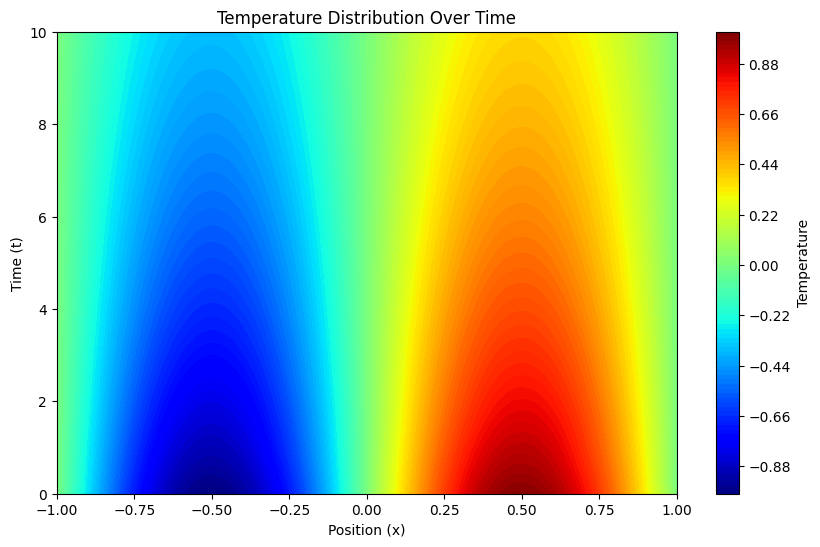

In [17]:
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

alpha = 0.01
epochs = 5000
xBound = (-1, 1)
tBound = (0, 10)

lossVec1 = train(model, optimizer, alpha, epochs)

plotSolution(model, xBound, tBound)

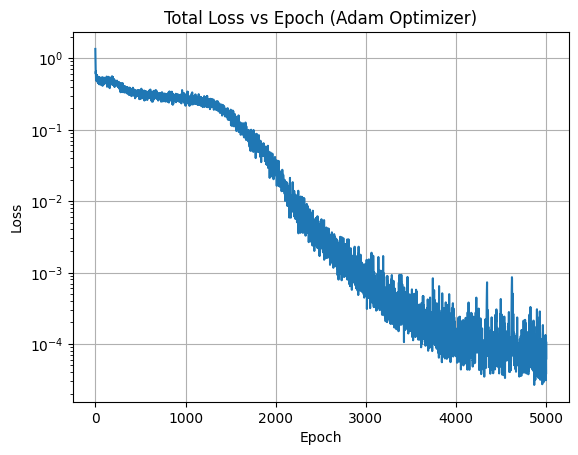

In [18]:
plt.semilogy(range(epochs), lossVec1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss vs Epoch (Adam Optimizer)')
plt.grid()

### Optimized Optimizer

In [19]:
alpha = 0.01
opEpochs = 2000
xBound = (-1, 1)
tBound = (0, 10)

lrs = [0.0003, 0.001, 0.003, 0.01]
beta1s = [0.8, 0.9, 0.99]
beta2s = [0.99, 0.999, 0.9999]
epsilons = [1e-7, 1e-8, 1e-9]

count = len(lrs) * len(beta1s) * len(beta2s) * len(epsilons)
i = 1

finalLosses = []
minLoss = 1e3
lrBest = 0
beta1Best = 0
beta2Best = 0
epsilonBest = 0

for lr in lrs:
    for beta1 in beta1s:
        for beta2 in beta2s:
            for epsilon in epsilons:
                model = PINN().to(device)

                optimizer = optim.Adam(model.parameters(), lr = lr,
                                       betas = (beta1, beta2), eps = epsilon)
                lossVec = train(model, optimizer, alpha,
                                opEpochs, learning = True)

                finalLosses.append(np.mean(lossVec[-10:-1]))

                if np.mean(lossVec[-10:-1]) < minLoss:
                    minLoss = np.mean(lossVec[-10:-1])
                    lrBest = lr
                    beta1Best = beta1
                    beta2Best = beta2
                    epsilonBest = epsilon

                print('Count {0:d} of {1:d}'.format(i, count))
                i = i + 1
                print('Final Loss: {0:.3e}, LR: {1:.3e}, Beta1: {2:.3e}, Beta2: {3:.3e}, Epsilon: {4:.3e}'.format(np.mean(lossVec[-10:-1]),
                                                                                                                  lr,
                                                                                                                  beta1,
                                                                                                                  beta2,
                                                                                                                  epsilon))
                print('----------------------------------')

print('Best Optimizer Parameters:')
print('LR: {0:.3e}'.format(lrBest))
print('Beta1: {0:.3e}'.format(beta1Best))
print('Beta2: {0:.3e}'.format(beta2Best))
print('Epsilon: {0:.3e}'.format(epsilonBest))

Count 1 of 108
Final Loss: 3.160e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.900e-01, Epsilon: 1.000e-07
----------------------------------
Count 2 of 108
Final Loss: 3.103e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.900e-01, Epsilon: 1.000e-08
----------------------------------
Count 3 of 108
Final Loss: 3.109e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.900e-01, Epsilon: 1.000e-09
----------------------------------
Count 4 of 108
Final Loss: 3.123e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.990e-01, Epsilon: 1.000e-07
----------------------------------
Count 5 of 108
Final Loss: 3.170e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.990e-01, Epsilon: 1.000e-08
----------------------------------
Count 6 of 108
Final Loss: 2.992e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.990e-01, Epsilon: 1.000e-09
----------------------------------
Count 7 of 108
Final Loss: 2.888e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.999e-01, Epsilon: 1.000e-07
----------------------------------

Epoch 0, PDE Loss: 1.8840962923150073e-07, Initial Loss: 0.6348491907119751, Boundary Loss: 0.245618999004364
Epoch 1000, PDE Loss: 6.807839235989377e-05, Initial Loss: 0.00013365392806008458, Boundary Loss: 0.00019076146418228745
Epoch 2000, PDE Loss: 1.93689425032062e-06, Initial Loss: 6.896504146425286e-06, Boundary Loss: 3.5435436984698754e-06
Epoch 3000, PDE Loss: 6.837204296061827e-07, Initial Loss: 1.0385043424321339e-05, Boundary Loss: 9.088618753594346e-06
Epoch 4000, PDE Loss: 4.031454636788112e-07, Initial Loss: 2.175127974624047e-06, Boundary Loss: 8.193921530619264e-06


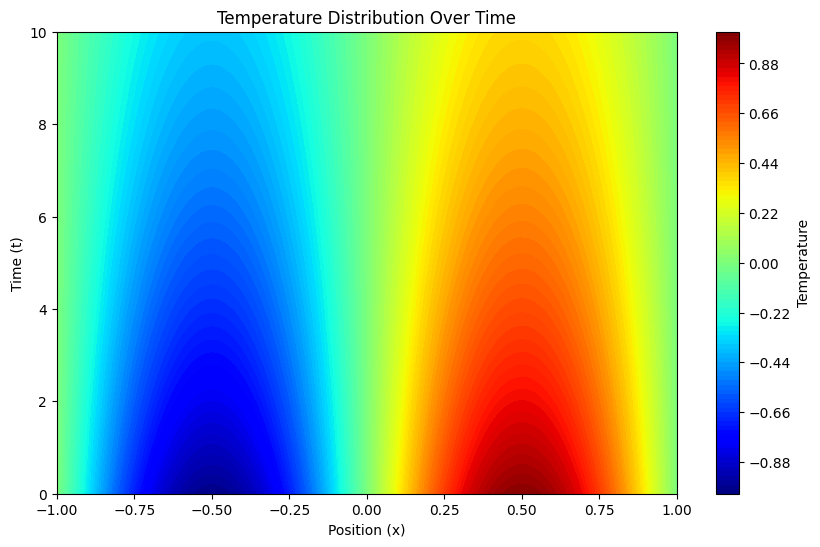

In [20]:
epochs = 5000
model2 = PINN().to(device)

optimizerBest = optim.Adam(model2.parameters(), lr=lrBest,
                           betas=(beta1Best, beta2Best), eps=epsilonBest)

lossVec2 = train(model2, optimizerBest, alpha, epochs)

plotSolution(model2, xBound, tBound)

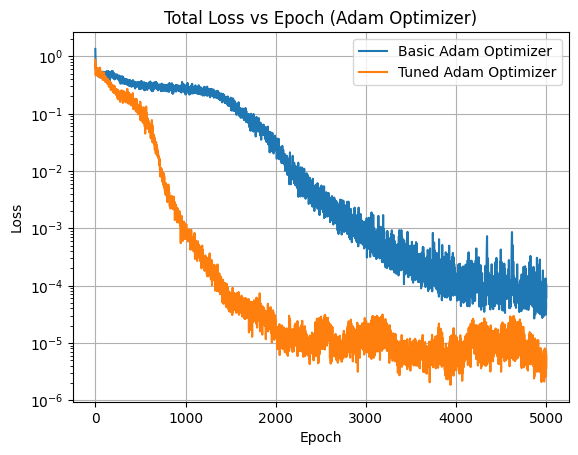

In [21]:
plt.semilogy(range(epochs), lossVec1, label = 'Basic Adam Optimizer')
plt.semilogy(range(epochs), lossVec2, label = 'Tuned Adam Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss vs Epoch (Adam Optimizer)')
plt.legend()
plt.grid()
plt.show()

### Numerical Solution

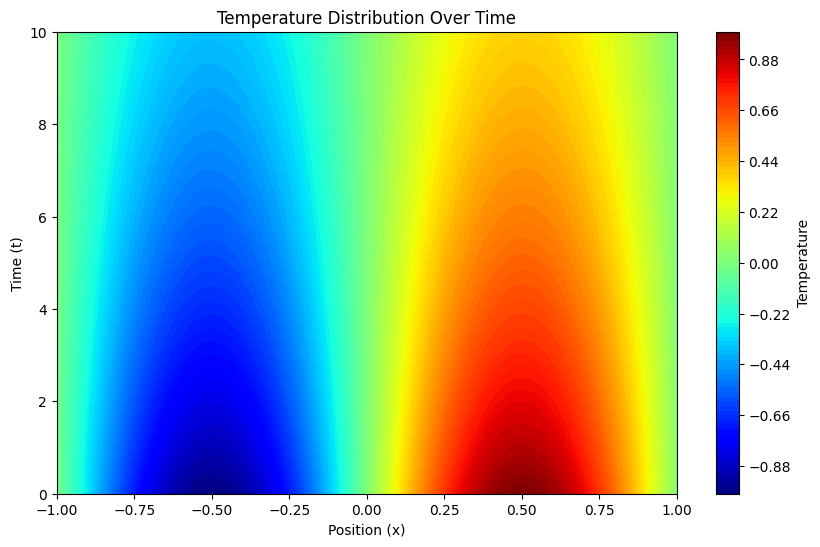

In [22]:
def u0(x):
    return np.sin(np.pi * x)

xBound = (-1, 1)
xSteps = 100
tBound = (0, 10)
tSteps = 100

L = xBound[1] - xBound[0]
xx = np.linspace(xBound[0], xBound[1], xSteps)
t = np.linspace(tBound[0], tBound[1], tSteps)
tt = np.linspace(tBound[0], tBound[1], tSteps*20)

T, X = np.meshgrid(t, xx, indexing='ij')

def Heat(u, t, L, alpha):
    uxx = psdiff(u, period=L, order=2)
    ut = alpha * uxx
    return ut

def solveHeat(u0, t, L, alpha):
    sol = odeint(Heat, u0, t, args=(L, alpha,))
    return sol

ureference = solveHeat(u0(xx), tt, L, alpha)
ureference = ureference[::20,]

plt.figure(figsize=(10, 6))
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Temperature Distribution Over Time')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')
plt.show()

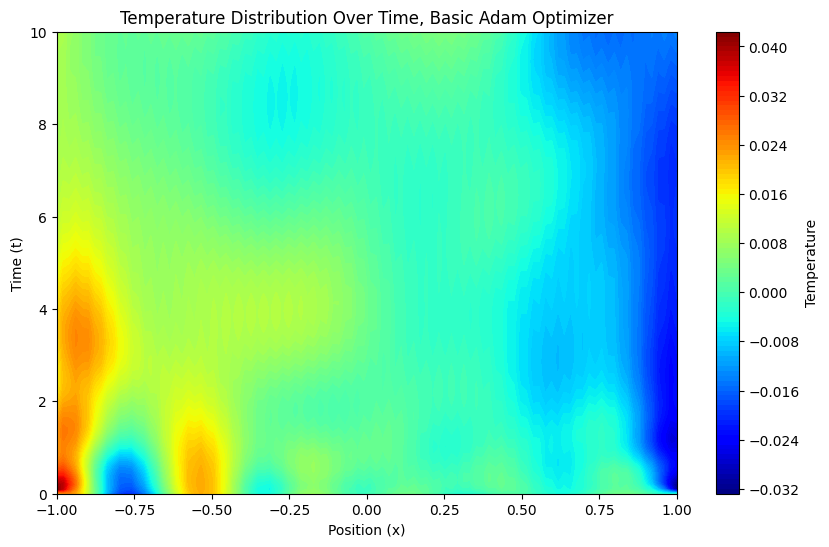

In [23]:
U1 = returnGrid(model, xBound, tBound)

plt.figure(figsize=(10, 6))
plt.contourf(X, T, U1 - ureference, 100, cmap=plt.cm.jet)
plt.title('Temperature Distribution Over Time, Basic Adam Optimizer')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')
plt.show()

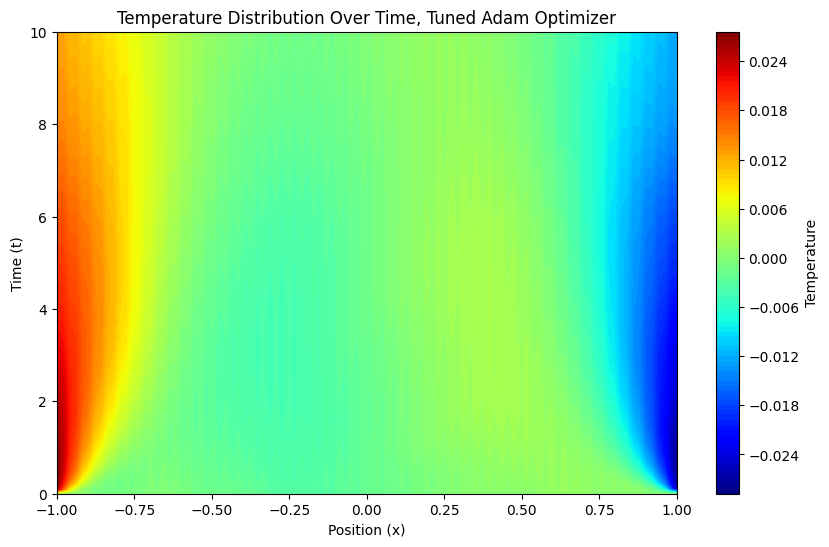

In [24]:
U2 = returnGrid(model2, xBound, tBound)

plt.figure(figsize=(10, 6))
plt.contourf(X, T, U2 - ureference, 100, cmap=plt.cm.jet)
plt.title('Temperature Distribution Over Time, Tuned Adam Optimizer')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')
plt.show()

## Heat Soak from Walls

In [25]:
def icLoss(model, x):
    u0 = model(torch.cat([x, torch.zeros_like(x)], dim=1))
    fx = torch.zeros_like(u0)
    return torch.mean((u0 - fx)**2)

def bcLoss(model, t):
    xLeft = torch.full((t.shape[0], 1), -1.0)
    xRight = torch.full((t.shape[0], 1), 1.0)

    uLeft = model(torch.cat([xLeft, t], dim=1))
    uRight = model(torch.cat([xRight, t], dim=1))

    g1t = torch.ones_like(uLeft)
    g2t = torch.ones_like(uRight)

    return torch.mean((uLeft - g1t)**2) + torch.mean((uRight - g2t)**2)

### Adam Optimizer

Epoch 0, PDE Loss: 2.0934450617460243e-07, Initial Loss: 0.1840500384569168, Boundary Loss: 4.095386981964111
Epoch 1000, PDE Loss: 0.04703754559159279, Initial Loss: 0.031022900715470314, Boundary Loss: 0.08153988420963287
Epoch 2000, PDE Loss: 0.030247515067458153, Initial Loss: 0.02880360558629036, Boundary Loss: 0.07888688892126083
Epoch 3000, PDE Loss: 0.008085409179329872, Initial Loss: 0.04648508131504059, Boundary Loss: 0.019412783905863762
Epoch 4000, PDE Loss: 0.0018533512484282255, Initial Loss: 0.03566775470972061, Boundary Loss: 0.013081535696983337
Epoch 5000, PDE Loss: 0.0026513105258345604, Initial Loss: 0.018860341981053352, Boundary Loss: 0.017329983413219452
Epoch 6000, PDE Loss: 0.006706900428980589, Initial Loss: 0.016433466225862503, Boundary Loss: 0.006482819095253944
Epoch 7000, PDE Loss: 0.001005727332085371, Initial Loss: 0.005784937646239996, Boundary Loss: 0.003969063051044941
Epoch 8000, PDE Loss: 0.0007562145474366844, Initial Loss: 0.005404097028076649, B

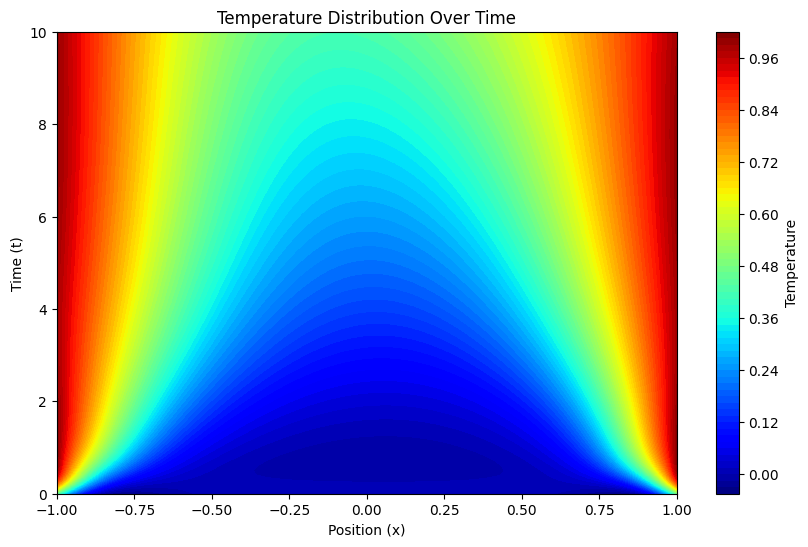

In [26]:
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

alpha = 0.03
epochs = 10000
xBound = (-1, 1)
tBound = (0, 10)
pdeWeight = 2

lossVec1 = train(model, optimizer, alpha, epochs, pdeWeight)

plotSolution(model, xBound, tBound)

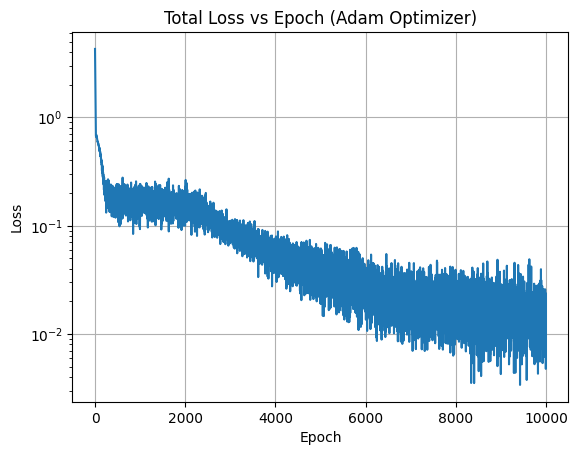

In [27]:
plt.semilogy(range(epochs), lossVec1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss vs Epoch (Adam Optimizer)')
plt.grid()

### Optimized Optimizer

In [28]:
alpha = 0.03
opEpochs = 2000
xBound = (-1, 1)
tBound = (0, 10)
pdeWeight = 2

lrs = [0.0003, 0.001, 0.003, 0.01]
beta1s = [0.8, 0.9, 0.99]
beta2s = [0.99, 0.999, 0.9999]
epsilons = [1e-7, 1e-8, 1e-9]

count = len(lrs) * len(beta1s) * len(beta2s) * len(epsilons)
i = 1

finalLosses = []
minLoss = 1e3
lrBest = 0
beta1Best = 0
beta2Best = 0
epsilonBest = 0

for lr in lrs:
    for beta1 in beta1s:
        for beta2 in beta2s:
            for epsilon in epsilons:
                model = PINN().to(device)

                optimizer = optim.Adam(model.parameters(), lr = lr,
                                       betas = (beta1, beta2), eps = epsilon)
                lossVec = train(model, optimizer, alpha,
                                opEpochs, pdeWeight, learning = True)

                finalLosses.append(np.mean(lossVec[-10:-1]))

                if np.mean(lossVec[-10:-1]) < minLoss:
                    minLoss = np.mean(lossVec[-10:-1])
                    lrBest = lr
                    beta1Best = beta1
                    beta2Best = beta2
                    epsilonBest = epsilon

                print('Count {0:d} of {1:d}'.format(i, count))
                i = i + 1
                print('Final Loss: {0:.3e}, LR: {1:.3e}, Beta1: {2:.3e}, Beta2: {3:.3e}, Epsilon: {4:.3e}'.format(np.mean(lossVec[-10:-1]),
                                                                                                                  lr,
                                                                                                                  beta1,
                                                                                                                  beta2,
                                                                                                                  epsilon))
                print('----------------------------------')

print('Best Optimizer Parameters:')
print('LR: {0:.3e}'.format(lrBest))
print('Beta1: {0:.3e}'.format(beta1Best))
print('Beta2: {0:.3e}'.format(beta2Best))
print('Epsilon: {0:.3e}'.format(epsilonBest))

Count 1 of 108
Final Loss: 1.617e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.900e-01, Epsilon: 1.000e-07
----------------------------------
Count 2 of 108
Final Loss: 1.800e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.900e-01, Epsilon: 1.000e-08
----------------------------------
Count 3 of 108
Final Loss: 1.752e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.900e-01, Epsilon: 1.000e-09
----------------------------------
Count 4 of 108
Final Loss: 1.656e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.990e-01, Epsilon: 1.000e-07
----------------------------------
Count 5 of 108
Final Loss: 1.630e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.990e-01, Epsilon: 1.000e-08
----------------------------------
Count 6 of 108
Final Loss: 1.472e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.990e-01, Epsilon: 1.000e-09
----------------------------------
Count 7 of 108
Final Loss: 1.754e-01, LR: 3.000e-04, Beta1: 8.000e-01, Beta2: 9.999e-01, Epsilon: 1.000e-07
----------------------------------

Epoch 0, PDE Loss: 2.1573011821374166e-08, Initial Loss: 0.003514333162456751, Boundary Loss: 2.2435057163238525
Epoch 1000, PDE Loss: 0.0011401637457311153, Initial Loss: 0.018961895257234573, Boundary Loss: 0.014492507092654705
Epoch 2000, PDE Loss: 0.00016528472770005465, Initial Loss: 0.0033563862089067698, Boundary Loss: 0.004605748690664768
Epoch 3000, PDE Loss: 0.0002148723287973553, Initial Loss: 0.0024269185960292816, Boundary Loss: 0.01097794994711876
Epoch 4000, PDE Loss: 0.000122775774798356, Initial Loss: 0.003611382795497775, Boundary Loss: 0.004233839455991983
Epoch 5000, PDE Loss: 0.00011820872168755159, Initial Loss: 0.0028822901658713818, Boundary Loss: 0.007193155121058226
Epoch 6000, PDE Loss: 0.00019024647190235555, Initial Loss: 0.0027649137191474438, Boundary Loss: 0.0014652051031589508
Epoch 7000, PDE Loss: 0.0001886006211861968, Initial Loss: 0.002909068251028657, Boundary Loss: 0.0035678697749972343
Epoch 8000, PDE Loss: 0.00037781125865876675, Initial Loss: 0

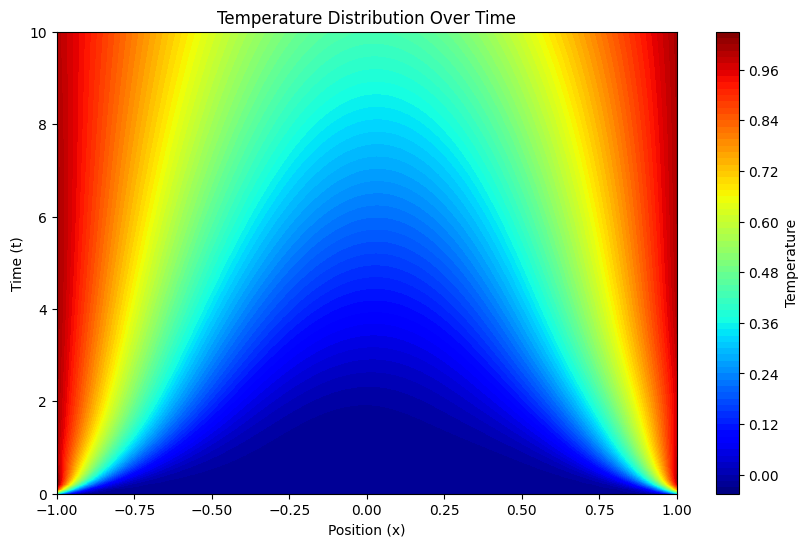

In [29]:
epochs = 10000
model2 = PINN().to(device)

optimizerBest = optim.Adam(model2.parameters(), lr=lrBest,
                           betas=(beta1Best, beta2Best), eps=epsilonBest)

lossVec2 = train(model2, optimizerBest, alpha, epochs)

plotSolution(model2, xBound, tBound)

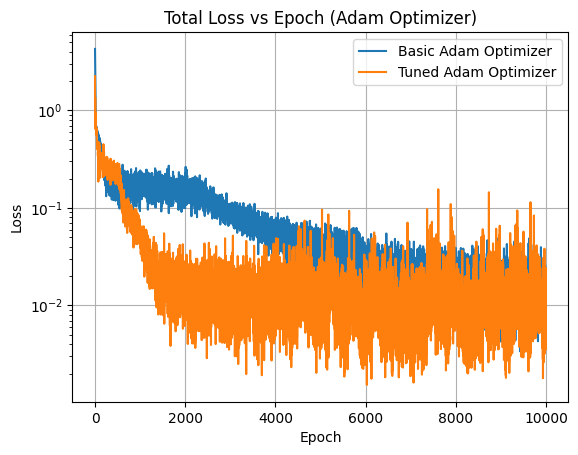

In [30]:
plt.semilogy(range(epochs), lossVec1, label = 'Basic Adam Optimizer')
plt.semilogy(range(epochs), lossVec2, label = 'Tuned Adam Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss vs Epoch (Adam Optimizer)')
plt.legend()
plt.grid()
plt.show()

### Numerical Solution

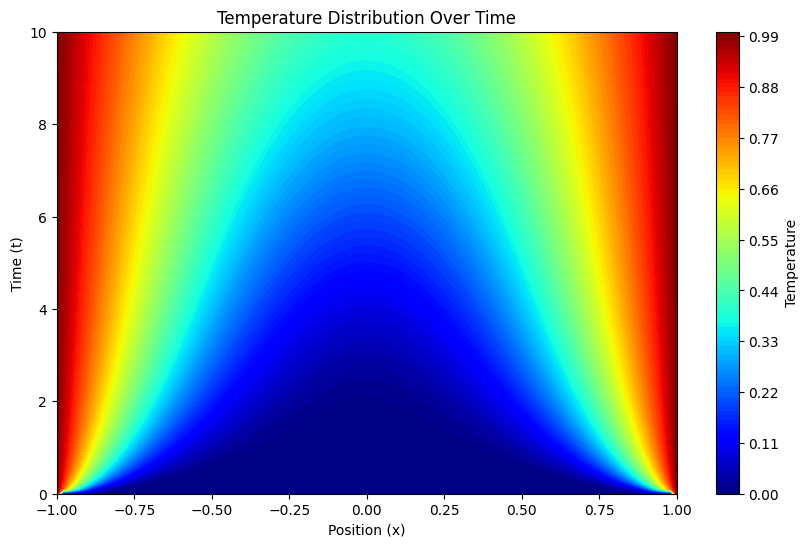

In [31]:
xBound = (-1, 1)
xSteps = 100
tBound = (0, 10)
tSteps = 100

L = xBound[1] - xBound[0]
xx = np.linspace(xBound[0], xBound[1], xSteps)
t = np.linspace(tBound[0], tBound[1], tSteps)
tt = np.linspace(tBound[0], tBound[1], tSteps*20)

dt = tt[1]
dx = L / xSteps

T, X = np.meshgrid(t, xx, indexing='ij')

ureference = np.zeros([tSteps * 20, xSteps])
ureference[:, 0] = 1
ureference[:, -1] = 1

for t in range(1, tSteps * 20 - 1):
    for x in range(1, xSteps - 1):
        ureference[t + 1, x] = ureference[t, x] + alpha * (ureference[t, x + 1] -
                                                           2 * ureference[t, x] +
                                                           ureference[t, x - 1]) * (dt / dx**2)

ureference = ureference[::20,]

plt.figure(figsize=(10, 6))
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Temperature Distribution Over Time')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')
plt.show()

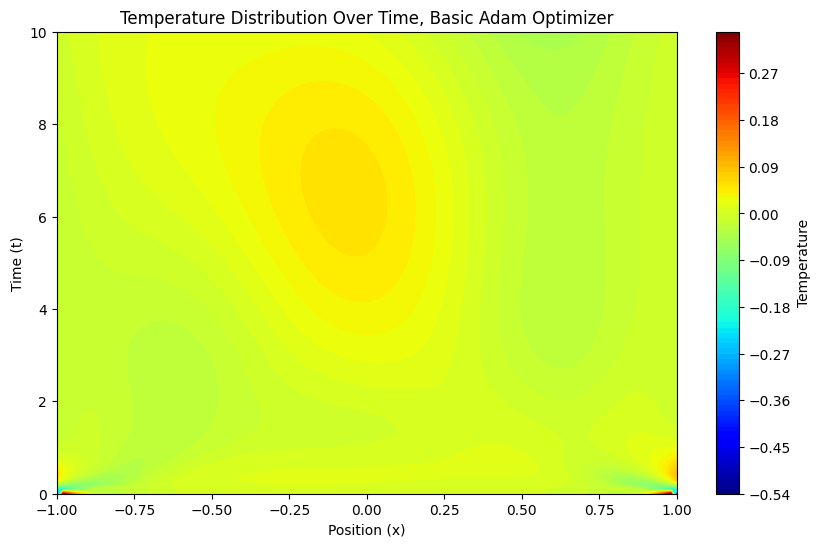

In [32]:
U1 = returnGrid(model, xBound, tBound)

plt.figure(figsize=(10, 6))
plt.contourf(X, T, U1 - ureference, 100, cmap=plt.cm.jet)
plt.title('Temperature Distribution Over Time, Basic Adam Optimizer')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')
plt.show()

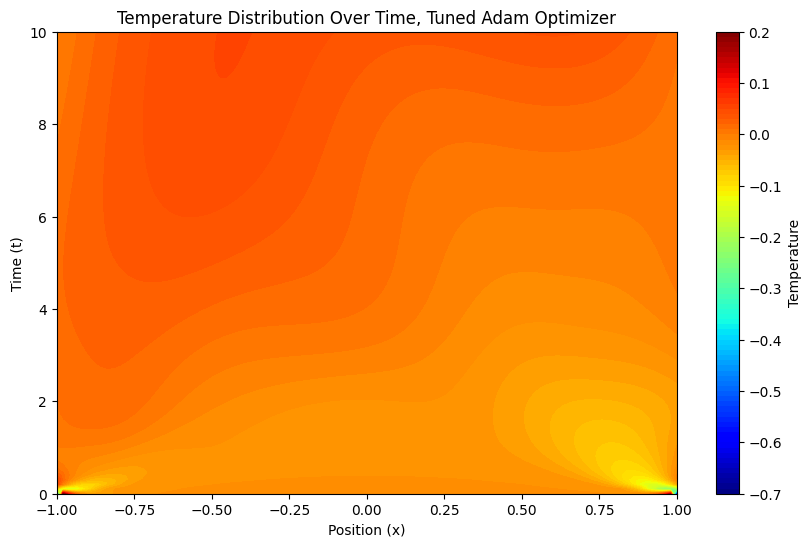

In [33]:
U2 = returnGrid(model2, xBound, tBound)

plt.figure(figsize=(10, 6))
plt.contourf(X, T, U2 - ureference, 100, cmap=plt.cm.jet)
plt.title('Temperature Distribution Over Time, Tuned Adam Optimizer')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')
plt.show()

In [34]:
total_params = sum(p.numel() for p in model2.parameters())
print(f'Our PINN has a total of {total_params} parameters')

Our PINN has a total of 8481 parameters


In [36]:
!pip freeze

absl-py==1.4.0
accelerate==0.34.2
aiohappyeyeballs==2.4.3
aiohttp==3.10.10
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.4
astropy-iers-data==0.2024.10.28.0.34.7
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.25.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1